In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
import statsmodels.api as sm
import shapely
import pysal as ps
import seaborn as sns
from matplotlib import colors

#### Loading Census Tract Shapefile

In [2]:
shape_path = "ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

In [3]:
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area = ct_shape.to_crs(epsg=2263).geometry.area.sum() / (2.788 * 10 ** 7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


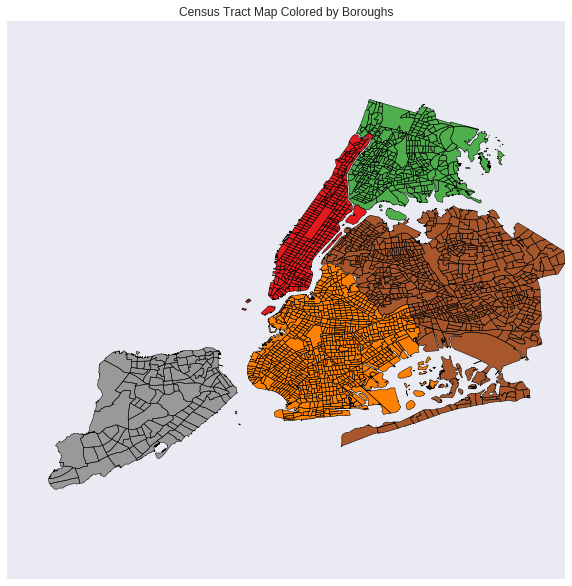

In [4]:
#visualize census tract boundariers colored by borough 
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column = 'BoroCode',alpha = 1,linewidth=0.5,ax = ax)
plt.title("Census Tract Map Colored by Boroughs")

### Figure 1. Census Tracts of New York City Boroughs
#### Boroughs are represented by color

In [5]:
#load census data for 2010
ct_data = DataFrame.from_csv("ACS_CT2010.csv")
#set index to be the BoroCT2010 code
ct_data.index = ct_data.BoroCT2010.astype(str)

In [6]:
#add population density to CT shaptefile
ct_shape_pop = ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

/opt/rh/anaconda/root/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


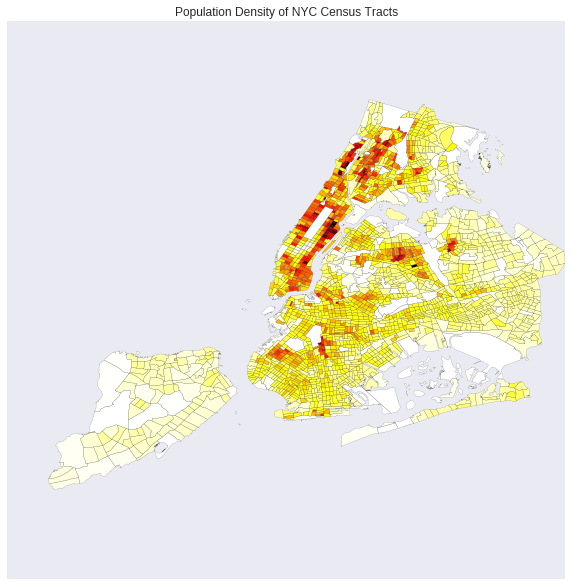

In [7]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column = 'SE_T002_002',colormap = 'hot_r',alpha = 1,linewidth = 0.1,ax = ax)
plt.legend()
plt.title("Population Density of NYC Census Tracts")

### Figure 2. Population Density of New York City by Census Tract
#### The most dense census tracts are located in Eastern Manhattan and the Bronx 

In [8]:
#load Citibike data
df_bike_monthly = DataFrame.from_csv("CitiBike_monthly_byStation.csv")
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


In [9]:
#create dataframe for summer months: April - September
df_bike_summer = df_bike_monthly.iloc[[0,1,2,9,10,11,12,13,14,21,22,23,24,25,26,33,34,35], :]
df_bike_summer.head(20)

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2014-04-30,1319,2315,7056,2371,4479,2266,1417,3288,3000,1540,...,0,0,0,0,0,0,0,0,0,0
2014-05-31,1696,3125,9070,3115,6207,2897,2049,3579,3863,2062,...,0,0,0,0,0,0,0,0,0,0
2014-06-30,2048,3306,9626,3515,7255,2942,1917,3702,3694,2422,...,0,0,0,0,0,0,0,0,0,0
2014-07-31,2252,3216,9825,3509,7014,3224,2195,3732,4042,2268,...,0,0,0,0,0,0,0,0,0,0
2014-08-31,2179,3004,10196,3573,7328,3311,2213,4078,4011,2168,...,0,0,0,0,0,0,0,0,0,0
2014-09-30,2281,3678,10357,3680,7740,3695,2217,4112,3504,2315,...,0,0,0,0,0,0,0,0,0,0


In [10]:
#create dataframe for winter months: October - March
df_bike_winter = df_bike_monthly.iloc[[3,4,5,6,7,8,15,16,17,18,19,20,27,28,29,30,31,32], :]
df_bike_winter.head(20)

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0
2013-12-31,1299,1650,4081,1686,3046,1575,830,1890,2048,1009,...,0,0,0,0,0,0,0,0,0,0
2014-01-31,956,1337,3178,1251,1920,1130,477,1412,1082,681,...,0,0,0,0,0,0,0,0,0,0
2014-02-28,650,960,2920,676,1808,933,508,1045,963,530,...,0,0,0,0,0,0,0,0,0,0
2014-03-31,804,1559,5102,1441,2643,1477,849,2004,2105,880,...,0,0,0,0,0,0,0,0,0,0
2014-10-31,2213,3121,8881,3268,6624,4106,1798,3989,3270,2193,...,0,0,0,0,0,0,0,0,0,0
2014-11-30,1437,1863,5980,2339,4069,2836,1148,2584,2109,1399,...,0,0,0,0,0,0,0,0,0,0
2014-12-31,1052,1304,4501,1783,2985,2091,779,2108,1636,878,...,0,0,0,0,0,0,0,0,0,0


/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


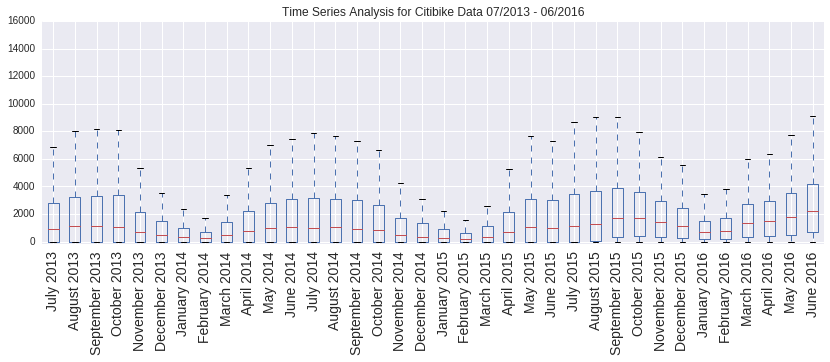

In [11]:
#Time series analysis for all data
plt.rcParams['font.size'] = 14
f, ax = plt.subplots(figsize = (14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_ = df_bike_monthly.copy()
df_bike_monthly_.index = df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize = (15,7),ax = ax,rot = 90);
ax.set_ylim([-200,16000])
plt.title('Time Series Analysis for Citibike Data 07/2013 - 06/2016')

### Figure 3. Time Series Analysis of Citibike Data for the Months of July 2014 Through June 2016
#### The results show a period trend in Citibike ridership increasing during the summer months 

/opt/rh/anaconda/root/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


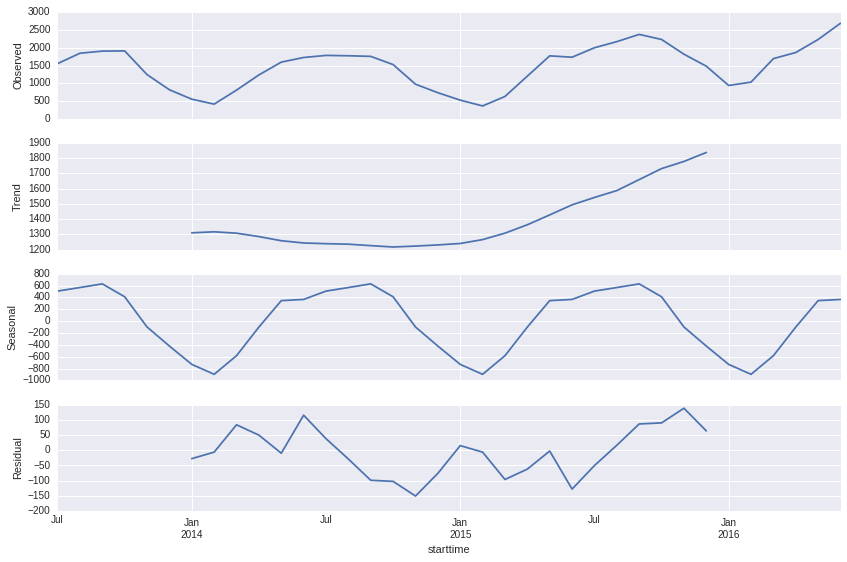

In [12]:
#seasonal decomposition

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new = df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace = True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize'] = (12,8)
resplot = res.plot()

### Figure 4. Seasonal Decomposition by Citibike Monthly Average
#### The results further show the change of ridership from summer months and winter months

In [13]:
#mapping Citibike data to CT level
station_id = DataFrame.from_csv("Station_id.csv")
#convert station_ids to string index
station_id.index = station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


In [14]:
#create Citibike station geometry from coordinates

# combine lat and lon to one column
station_id['lonlat'] = zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry'] = station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


In [15]:
#intersect the two geometries
a = []
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i + 1) * 100. / len(station_id))[:4],
station_id['BoroCT2010'] = a

% 100.


In [16]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [17]:
#monthly riders for summer months
station_id['MonthlyAveS'] = df_bike_summer.sum()

In [18]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAveS
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,42378
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,67646
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,169085
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,64084
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,116324


In [19]:
#monthly riders for winter months
station_id['MonthlyAveW'] = df_bike_winter.sum()

In [20]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAveS,MonthlyAveW
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,42378,26930
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,67646,35178
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,169085,104440
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,64084,37865
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,116324,67720


In [21]:
#add monthly average rides to CT shapefile
temp1 = station_id[['MonthlyAveS']]
temp1['station_id'] = station_id.index
temp1.index = station_id['BoroCT2010']
ct_shape_MonthlyAveS = ct_shape.join(temp1)
ct_shape_MonthlyAveS.fillna(0,inplace=True)

temp2 = station_id[['MonthlyAveW']]
temp2['station_id'] = station_id.index
temp2.index = station_id['BoroCT2010']
ct_shape_MonthlyAveW = ct_shape.join(temp2)
ct_shape_MonthlyAveW.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


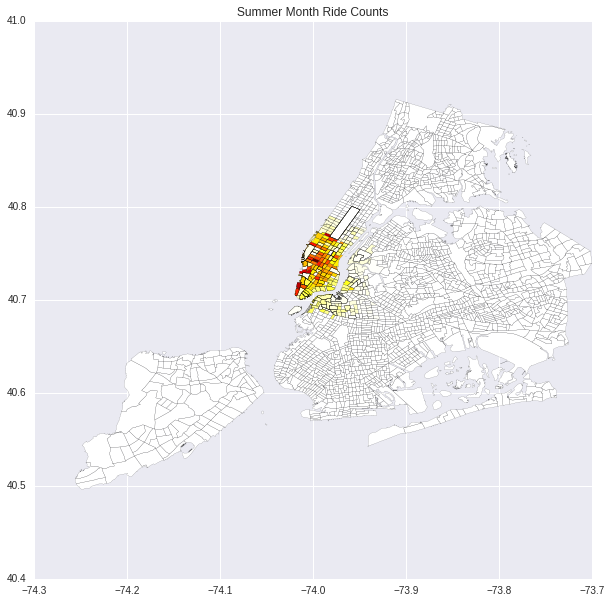

In [22]:
#monthly ride count for summer
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAveS.plot(column = 'MonthlyAveS',colormap = 'hot_r',alpha = 1,linewidth = 0.1,ax = ax)
plt.title("Summer Month Ride Counts")

### Figure 5. Average Ride Count for Summer Months
#### Average ride count is displayed by census tract

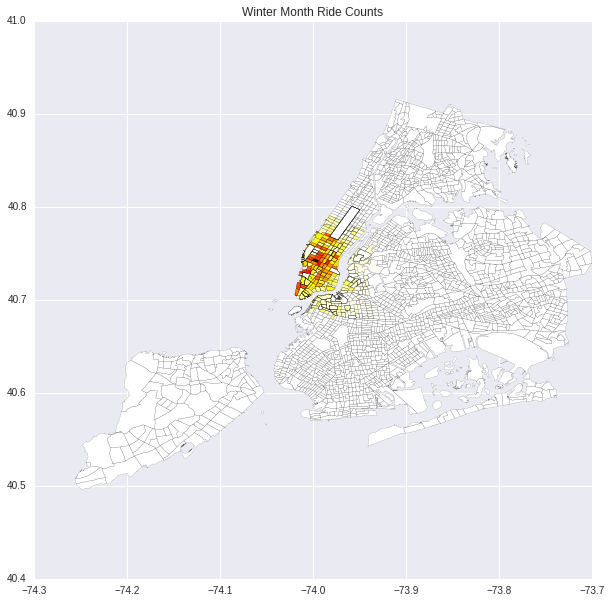

In [23]:
#monthly ride count for winter
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAveW.plot(column = 'MonthlyAveW',colormap = 'hot_r',alpha = 1,linewidth = 0.1,ax = ax)
plt.title("Winter Month Ride Counts")

### Figure 6. Average Ride Count for Winter Months
#### Average ride count is displayed by census tract

In [24]:
#removing census tracts outside of the zoomed in area that removes tracts with no data for summer months
ct_shape_MonthlyAveS_Zoom = (ct_shape_MonthlyAveS[ct_shape_MonthlyAveS
                           .centroid
                           .apply(lambda c:c.x > -74.1 and c.x < -73.92 and c.y > 40.65 and c.y < 40.8)])

In [25]:
#confirm size of zoomed census tracts
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp1.MonthlyAveS)

Total number of CTs: 2166
Number of zoomed CTs: 543


In [26]:
#removing census tracts outside of the zoomed in area that removes tracts with no data for winter months
ct_shape_MonthlyAveW_Zoom = (ct_shape_MonthlyAveW[ct_shape_MonthlyAveW
                           .centroid
                           .apply(lambda c:c.x > -74.1 and c.x < -73.92 and c.y > 40.65 and c.y < 40.8)])

In [27]:
#confirm size of zoomed census tracts
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp2.MonthlyAveW)

Total number of CTs: 2166
Number of zoomed CTs: 543


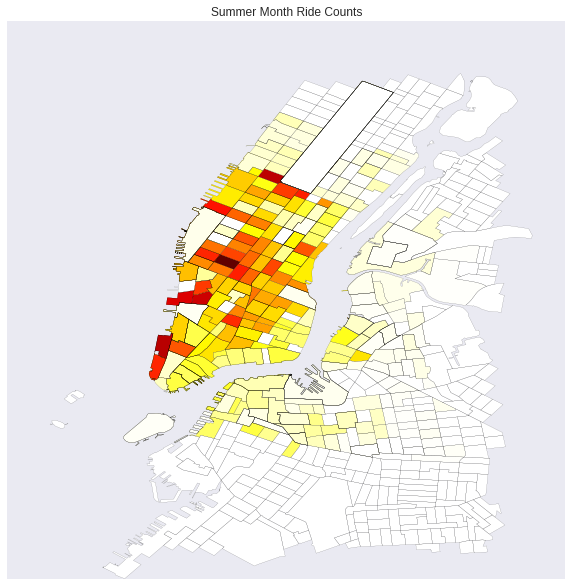

In [28]:
#plot the zoomed in figured of monthly summer average
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAveS_Zoom.plot(column = 'MonthlyAveS',colormap = 'hot_r',alpha = 1,linewidth = 0.1,ax = ax)
plt.title("Summer Month Ride Counts")

### Figure 7. Average Summer Month Ride Counts by Census Tract
#### This map shows only the census tracts where there is Citibike ridership data

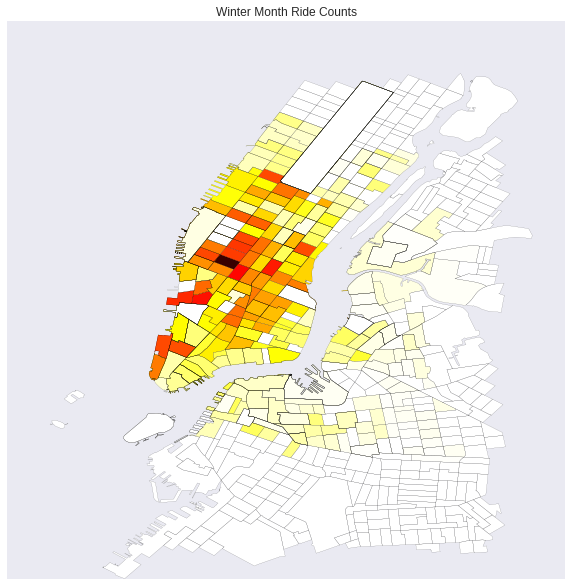

In [29]:
#plot the zoomed in figured of monthly winter average
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAveW_Zoom.plot(column = 'MonthlyAveW',colormap = 'hot_r',alpha = 1,linewidth = 0.1,ax = ax)
plt.title("Winter Month Ride Counts")

### Figure 8. Average Winter Month Ride Counts by Census Tract
#### This map shows only the census tracts where there is Citibike ridership data

In [30]:
#export the two new shapefiles
path = "ct_shape_MonthlyAveS_Zoom.shp"
ct_shape_MonthlyAveS_Zoom.to_file(path)

path = "ct_shape_MonthlyAveW_Zoom.shp"
ct_shape_MonthlyAveW_Zoom.to_file(path)

### Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [31]:
qW_CT = ps.queen_from_shapefile(path)

('Island id: ', [0])


In [32]:
#Neighbors of index10
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [33]:
qW_CT.cardinalities[10]

9

In [34]:
#matrix of weights
Wmatrix, ids = qW_CT.full()
print (Wmatrix)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  1.  0.  1.]
 [ 0.  0.  0. ...,  0.  1.  0.]]


In [35]:
#Change the matrix to be row-standardized
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag

In [36]:
#summer months
MonthlyRideS = ct_shape_MonthlyAveS_Zoom.MonthlyAveS
MonthlyRideSLag = ps.lag_spatial(qW_CT, MonthlyRideS)

In [37]:
MonthlyRideSLagQ10 = ps.Quantiles(MonthlyRideSLag, k = 10)
MonthlyRideSLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               140
    0.000 < x[i] <=   137.571                21
  137.571 < x[i] <=  2404.850                78
 2404.850 < x[i] <=  5510.364                80
 5510.364 < x[i] <= 11145.782                79
11145.782 < x[i] <= 16953.467                80
16953.467 < x[i] <= 36421.278                79
36421.278 < x[i] <= 52710.200                80
52710.200 < x[i] <= 61019.750                79
61019.750 < x[i] <= 94018.643                80

In [38]:
#winter months
MonthlyRideW = ct_shape_MonthlyAveW_Zoom.MonthlyAveW
MonthlyRideWLag = ps.lag_spatial(qW_CT, MonthlyRideW)

In [39]:
MonthlyRideWLagQ10 = ps.Quantiles(MonthlyRideWLag, k = 10)
MonthlyRideWLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=   100.000                 2
  100.000 < x[i] <=  1652.442                78
 1652.442 < x[i] <=  4131.471                80
 4131.471 < x[i] <=  6582.023                79
 6582.023 < x[i] <=  9880.056                80
 9880.056 < x[i] <= 21830.992                79
21830.992 < x[i] <= 29977.138                80
29977.138 < x[i] <= 35912.227                79
35912.227 < x[i] <= 57964.714                80

### Map Summer Monthly Rides Lag

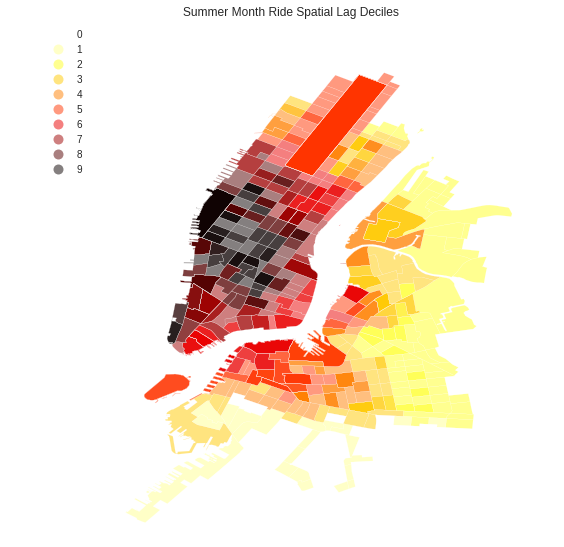

In [40]:
f, ax = plt.subplots(figsize = (9, 9))
ct_shape_MonthlyAveS_Zoom.assign(cl = MonthlyRideSLagQ10.yb).plot(column = 'cl', categorical = True, 
        k = 10, cmap = 'hot_r', linewidth = 0.1, ax = ax, 
        edgecolor = 'white', legend = True)
ax.set_axis_off()
plt.title("Summer Month Ride Spatial Lag Deciles")


### Figure 9. Similarity of Neighbors  in Summer Months by 10 Quantiles

### Map Winter Monthly Rides Lag

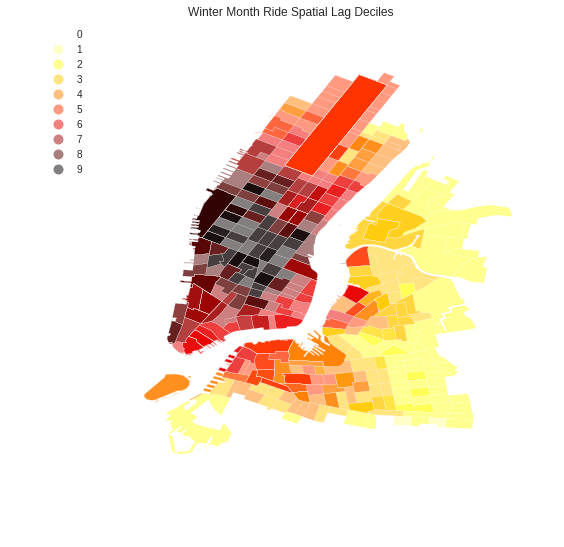

In [41]:
f, ax = plt.subplots(figsize = (9, 9))
ct_shape_MonthlyAveW_Zoom.assign(cl = MonthlyRideWLagQ10.yb).plot(column = 'cl', categorical = True, 
        k = 10, cmap = 'hot_r', linewidth = 0.1, ax = ax, 
        edgecolor = 'white', legend = True)
ax.set_axis_off()
plt.title("Winter Month Ride Spatial Lag Deciles")

### Figure 10. Similarity of Neighbors  in Winter Months by 10 Quantiles

## Global  Spatial Autocorrelation

In [42]:
#for summer months
b,a = np.polyfit(MonthlyRideS, MonthlyRideSLag, 1)
b,a 

(0.64466687635049424, 8128.844260081486)

In [43]:
#for winter months
b,a = np.polyfit(MonthlyRideW, MonthlyRideWLag, 1)
b,a 

(0.65962241090192864, 4623.7815625116482)

### Moran Scatterplot for Summer Months

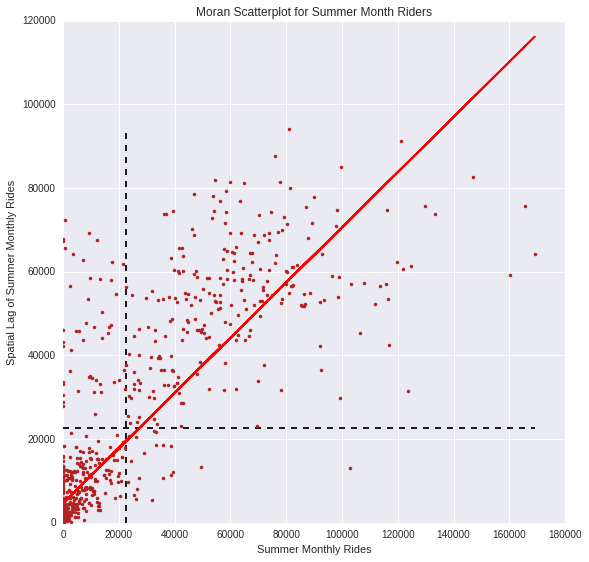

In [44]:
#for summer 
f, ax = plt.subplots(1, figsize = (9, 9))

plt.plot(MonthlyRideS, MonthlyRideSLag, '.', color = 'firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRideS.mean(), MonthlyRideSLag.min(), MonthlyRideSLag.max(), linestyle = '--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideSLag.mean(), MonthlyRideS.min(), MonthlyRideS.max(), linestyle = '--')

# red line of best fit using global I as slope
plt.plot(MonthlyRideS, a + b * MonthlyRideS, 'r')
plt.title('Moran Scatterplot for Summer Month Riders')
plt.ylabel('Spatial Lag of Summer Monthly Rides')
plt.xlabel('Summer Monthly Rides')

### Figure 11. Moran Scatter Plot of Summer Month Values
#### The scatter plot shows the majority of values fall within the quadrant of low values surronded by low values and than the quadrant for high values surronded by high values, both of which represent positive spatial autocorrelation

### Moran Scatterplot for Winter Months

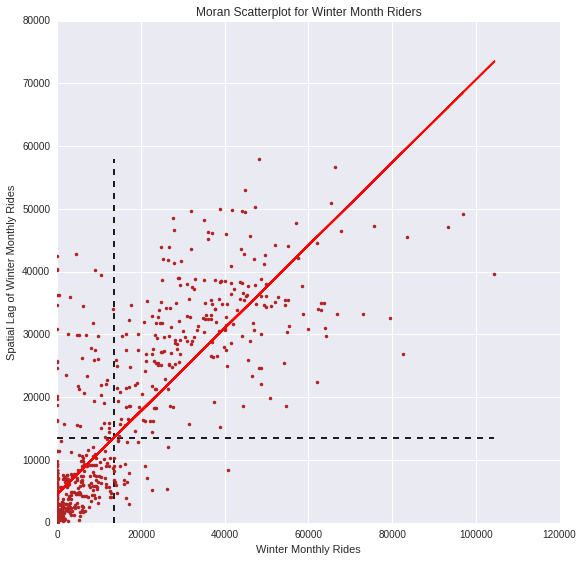

In [45]:
#for winter 
f, ax = plt.subplots(1, figsize = (9, 9))

plt.plot(MonthlyRideW, MonthlyRideWLag, '.', color = 'firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRideW.mean(), MonthlyRideWLag.min(), MonthlyRideWLag.max(), linestyle = '--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideWLag.mean(), MonthlyRideW.min(), MonthlyRideW.max(), linestyle = '--')

# red line of best fit using global I as slope
plt.plot(MonthlyRideW, a + b * MonthlyRideW, 'r')
plt.title('Moran Scatterplot for Winter Month Riders')
plt.ylabel('Spatial Lag of Winter Monthly Rides')
plt.xlabel('Winter Monthly Rides')

### Figure 12. Moran Scatter Plot of Winter Month Values
#### The scatter plot shows the majority of values fall within the quadrant of low values surronded by low values and than the quadrant for high values surronded by high values, both of which represent positive spatial autocorrelation

### Moran's I

In [46]:
#for summer
I_MonthlyRideS = ps.Moran(MonthlyRideS, qW_CT)

In [47]:
I_MonthlyRideS.I, I_MonthlyRideS.p_sim
#I statistic of .645, small p-value of .001

(0.64482518848460035, 0.001)

In [48]:
I_MonthlyRideS.sim[0:10]

array([-0.02095047, -0.01532539,  0.0191014 ,  0.01523403,  0.01023731,
       -0.00290343, -0.00524645,  0.01721293,  0.01513723,  0.01162755])

In [49]:
#for winter
I_MonthlyRideW = ps.Moran(MonthlyRideW, qW_CT)

In [50]:
I_MonthlyRideW.I, I_MonthlyRideW.p_sim
#I statistic of .66, small p-value of .001

(0.65977718610668423, 0.001)

In [51]:
I_MonthlyRideW.sim[0:10]

array([-0.003895  , -0.00827374, -0.00204991,  0.00036235, -0.00462819,
       -0.0130426 , -0.00189329,  0.02480513,  0.00476677, -0.01013906])

### KDEplot of all of the simulated points

In [52]:
plt.rcParams['figure.figsize'] = (14,3)

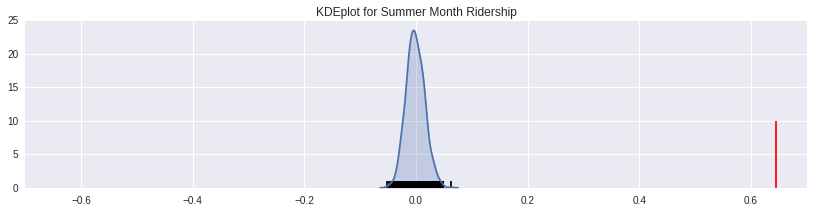

In [53]:
#for summer months
sns.kdeplot(I_MonthlyRideS.sim, shade = True)
plt.vlines(I_MonthlyRideS.sim, 0, 1)
plt.vlines(I_MonthlyRideS.I, 0, 10, 'r')
plt.xlim([-.70, .70])
plt.title('KDEplot for Summer Month Ridership')

### Figure 13. KDEplot for the Monthly Ridership for Summer Months
#### The red vertical line shows the observed value

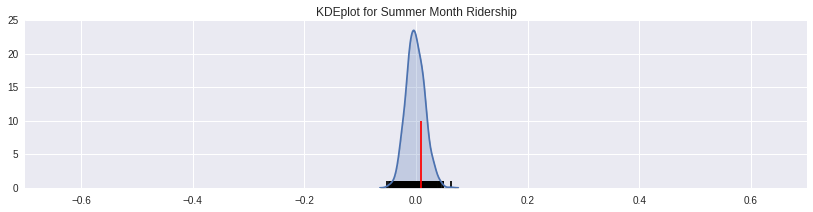

In [54]:
sns.kdeplot(I_MonthlyRideS.sim, shade=True)
plt.vlines(I_MonthlyRideS.sim, 0, 1)
plt.vlines(I_MonthlyRideS.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])
plt.title('KDEplot for Summer Month Ridership')

### Figure 14. KDEplot for Summer Months if I Statistic Were Close to Expect Value

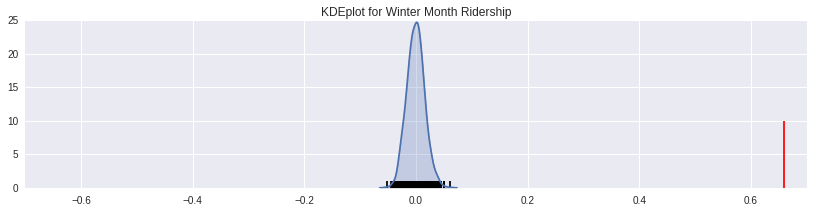

In [55]:
#for winter months
sns.kdeplot(I_MonthlyRideW.sim, shade = True)
plt.vlines(I_MonthlyRideW.sim, 0, 1)
plt.vlines(I_MonthlyRideW.I, 0, 10, 'r')
plt.xlim([-.70, .70])
plt.title('KDEplot for Winter Month Ridership')

### Figure 15. KDEplot for the Monthly Ridership for Winter Months
#### The red vertical line shows the observed value

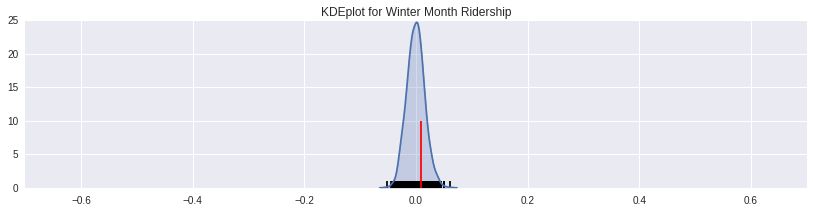

In [56]:
sns.kdeplot(I_MonthlyRideW.sim, shade=True)
plt.vlines(I_MonthlyRideW.sim, 0, 1)
plt.vlines(I_MonthlyRideW.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])
plt.title('KDEplot for Winter Month Ridership')

### Figure 16. KDEplot for Winter Months if I Statistic Were Close to Expect Value

## Local  Spatial Autocorrelation

In [57]:
#for summer months
LMo_MonthlyRideS = ps.Moran_Local(MonthlyRideS, qW_CT,permutations=999)

In [58]:
LMo_MonthlyRideS.Is[0:5], LMo_MonthlyRideS.p_sim[0:5]

(array([-0.        , -0.23934856,  0.01170042,  0.00166728,  0.021779  ]),
 array([ 0.001,  0.194,  0.356,  0.35 ,  0.385]))

In [59]:
#for winter months
LMo_MonthlyRideW = ps.Moran_Local(MonthlyRideW, qW_CT,permutations=999)

In [60]:
LMo_MonthlyRideW.Is[0:5], LMo_MonthlyRideW.p_sim[0:5]

(array([-0.        , -0.27131052,  0.000345  , -0.00107098, -0.04975374]),
 array([ 0.001,  0.169,  0.479,  0.499,  0.429]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [61]:
#summer 

sigs = MonthlyRideS[LMo_MonthlyRideS.p_sim <= .001]
W_sigs = MonthlyRideSLag[LMo_MonthlyRideS.p_sim <= .001]
insigs = MonthlyRideS[LMo_MonthlyRideS.p_sim > .001]
W_insigs = MonthlyRideSLag[LMo_MonthlyRideS.p_sim > .001]

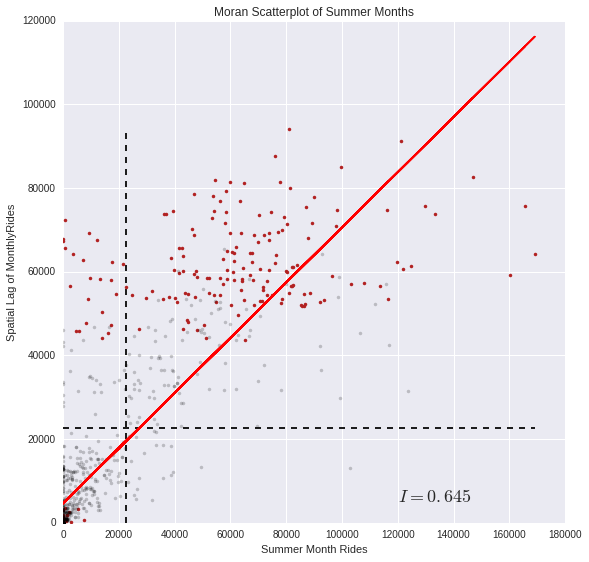

In [62]:
# Plot significant LISA for summer

f, ax = plt.subplots(figsize = (9, 9))
plt.plot(sigs, W_sigs, '.', color = 'firebrick')
plt.plot(insigs, W_insigs, '.k', alpha = .2)
plt.text(s = '$I = %.3f$' % I_MonthlyRideS.I, x = 120000, y = 5000, fontsize = 18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRideS.mean(), MonthlyRideSLag.min(), MonthlyRideSLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideSLag.mean(), MonthlyRideS.min(), MonthlyRideS.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRideS, a + b * MonthlyRideS, 'r')
plt.title('Moran Scatterplot of Summer Months')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('Summer Month Rides')


### Figure 17.  Local Indicators of Spatial Autocorrelation Shows Positive Spatial Autocorrelation

In [63]:
#winter 

sigsW = MonthlyRideW[LMo_MonthlyRideW.p_sim <= .001]
W_sigsW = MonthlyRideWLag[LMo_MonthlyRideW.p_sim <= .001]
insigsW = MonthlyRideW[LMo_MonthlyRideW.p_sim > .001]
W_insigsW = MonthlyRideWLag[LMo_MonthlyRideW.p_sim > .001]

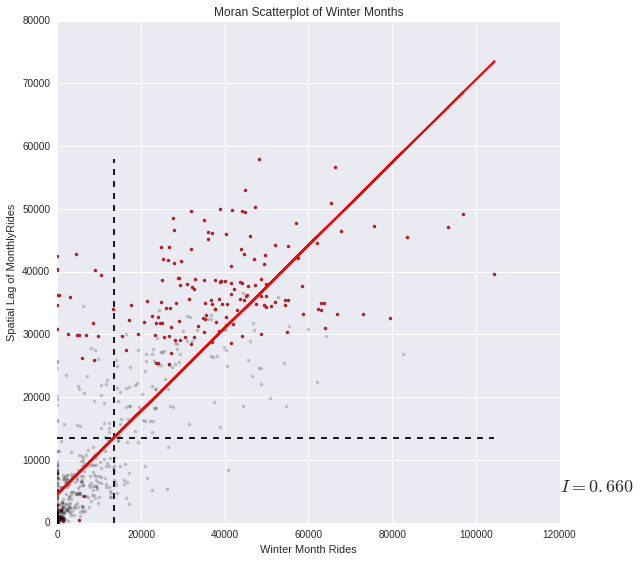

In [64]:
# Plot significant LISA for winter

f, ax = plt.subplots(figsize = (9, 9))
plt.plot(sigsW, W_sigsW, '.', color = 'firebrick')
plt.plot(insigsW, W_insigsW, '.k', alpha = .2)
plt.text(s = '$I = %.3f$' % I_MonthlyRideW.I, x = 120000, y = 5000, fontsize = 18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRideW.mean(), MonthlyRideWLag.min(), MonthlyRideWLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideWLag.mean(), MonthlyRideW.min(), MonthlyRideW.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRideW, a + b * MonthlyRideW, 'r')
plt.title('Moran Scatterplot of Winter Months')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('Winter Month Rides')

### Figure 18.  Local Indicators of Spatial Autocorrelation Shows Positive Spatial Autocorrelation

### Hot and Cold spots 

In [65]:
# summer months

sig = LMo_MonthlyRideS.p_sim < 0.01
hotspots = LMo_MonthlyRideS.q == 1 * sig
coldspots = LMo_MonthlyRideS.q == 3 * sig
print "Number of Hotspots:", hotspots.sum()
print "Number of Coldspots:", coldspots.sum()

Number of Hotspots: 186
Number of Coldspots: 237


In [66]:
# winter months

sigW = LMo_MonthlyRideW.p_sim < 0.01
hotspotsW = LMo_MonthlyRideW.q == 1 * sigW
coldspotsW = LMo_MonthlyRideW.q == 3 * sigW
print "Number of Hotspots:", hotspots.sum()
print "Number of Coldspots:", coldspots.sum()

Number of Hotspots: 186
Number of Coldspots: 237


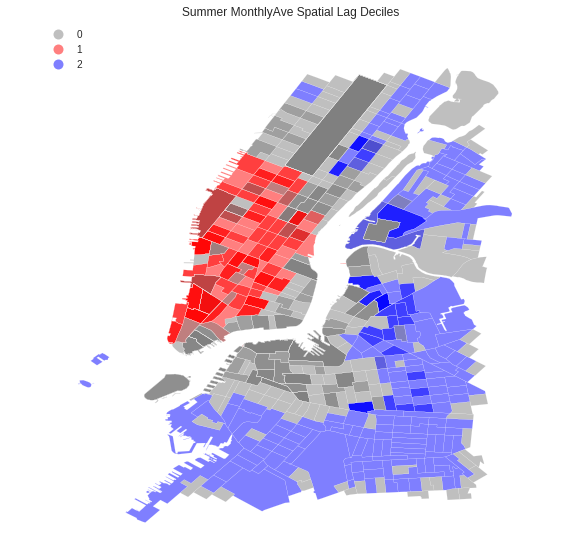

In [67]:
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAveS_Zoom.assign(cl = hotcold).plot(column = 'cl', categorical = True, 
        k = 10, cmap = hcmap, linewidth = 0.1, ax = ax, 
        edgecolor = 'white', legend = True)
ax.set_axis_off()
plt.title("Summer MonthlyAve Spatial Lag Deciles")

### Figure 19. Hot and Cold Spot for Summer Monthly Average by Census Tract
#### The hot spots in Manhattan show that Citibike riders in that area are riding and their neighbors are also riding while the cold spots in Brooklyn and Queens show that Citibike riders in those areas are not riding and their neighbors are also not riding. Both the hot and cold spots represent a positive spatial autocorrelation

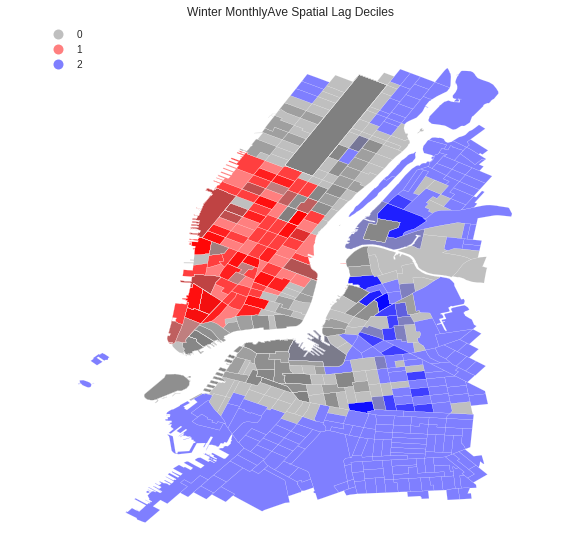

In [68]:
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcoldW = hotspotsW*1 + coldspotsW*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAveW_Zoom.assign(cl = hotcoldW).plot(column = 'cl', categorical = True, 
        k = 10, cmap = hcmap, linewidth = 0.1, ax = ax, 
        edgecolor = 'white', legend = True)
ax.set_axis_off()
plt.title("Winter MonthlyAve Spatial Lag Deciles")

### Figure 20. Hot and Cold Spot for Winter Monthly Average by Census Tract
#### The hot spots in Manhattan show that Citibike riders in that area are riding and their neighbors are also riding while the cold spots in Brooklyn and Queens show that Citibike riders in those areas are not riding and their neighbors are also not riding. Both the hot and cold spots represent a positive spatial autocorrelation